# Test irregular_time_sampling
- generate a dataset interpolated on irregular sampling
    - randomly sampled or from insitu dt trajectories
    - for insitu dt list, start randomly in this list + cycle and duplicate the list if too short
- see the different time sampling
- check CDF

In [22]:
import os
from glob import glob
import pandas as pd
import numpy as np
import xarray as xr
from sstats import tseries as ts
%matplotlib inline
from matplotlib import pyplot as plt

import hvplot.xarray
import holoviews as hv

import random
import warnings

import lib as lib
from lib import raw_dir, root_dir, images_dir, KEYS

In [64]:
def cyclic_selection(array, istart, replicate=1):
    """ 
    Return an array from an other array cycling and replicating 
    Parameters:
    -----------
            array : array to cycle or replicate
            istart : int, indice of the start in the given array 
            replicate : int,  number of replicate
    """
    cyclic_array = np.concatenate((array[istart:], array[0:istart]))
    if replicate ==1 : 
        return cyclic_array
    else : 
        return np.concatenate([cyclic_array]*replicate)

def cyclic_selection_len(array, istart,n):
    """ 
    Return an array from an other array cycling
    Parameters:
    -----------
            array : array to cycle or replicate
            istart : int, indice of the start in the given array 
            replicate : int,  number of replicate
    """
    narray = len(array)
    if n ==None : 
        n=narray
    if n > narray : 
        warnings.warn('dt dasaset to small, will contain duplicated values')
        
    if istart + n < narray : 
        return array[istart:istart+n]
    else : 
        return np.concatenate((array[istart:], array[0:n-narray+istart]))

def time_from_dt_array(tstart, tend, dt):
    """ 
    Return irregular sampled time list from the dt list. The starting dt in the dt list is randomly chosen and the list is replicated if needed
    Parameters:
    -----------
            tstart : np.datetime, starting time
            tend : np.datetime, ending time
            dt : list of dt
    """
    time_length = np.sum(dt) #total time length of the dt list
    replicate = (tend-tstart)//time_length+1
    if replicate > 1 : 
        warnings.warn('dt dasaset to small, will contain duplicated values of dt')
    istart = random.randrange(len(dt))
    print(istart)
    dt_ = cyclic_selection(dt, istart, replicate)

    time = xr.DataArray(tstart.values + np.cumsum(dt_))
    time = time.where(time<tend, drop=True)
    return time  



def irregular_time_sampling(ds,t,dt=1/24, offset_type='random_uniform', file=None, inplace=False):
    """ 
    Return irregular sampled time dataset from a dt list or randomly.
    The starting dt in the dt list is randomly chosen and the list is replicated if needed.
    Positions are then interpolated on this new irregularly sampled time.
    Parameters:
    -----------
            tstart : np.datetime, starting time
            tend : np.datetime, ending time
            dt : list of dt
    """
    if not inplace : 
        ds=ds.copy()
        
    # Random sampling option
    if offset_type == 'random_uniform':
        offset = (ts.uniform(t, low=-dt/2, high=dt/2)*pd.Timedelta("1D")).data
        ds["time_off"] = (ds.time.dims, ds.time.data + offset)
    
    # Irregular dt from in situ trajectories
    elif offset_type in KEYS:
        path_dt = os.path.join(root_dir,'example_dt_list','dt_'+ offset_type+'.csv')
        typical_dt = pd.Timedelta('300s')
        DT = (pd.read_csv(path_dt)['dt']*pd.Timedelta("1s")).values
        ds["time_off"] = time_from_dt_array(ds.time.min(), ds.time.max(), DT)
        #time = ds.time.data
        #for frequency computation
        #time[1] = time[0]+typical_dt
        #ds['time'] = time
        
    # Irregular dt from GDP raw trajectories    
    elif offset_type == 'gdp_raw':
        path_dt = '/Users/mdemol/code/PhD/filtering/example_dt_list/'
        file = path_dt + '/gdpraw_dt.csv'
        typical_dt = pd.Timedelta('60min')
        DT = (pd.read_csv(path_dt + 'gdpraw_dt.csv')['dt']*pd.Timedelta("1min")).values
        ds["time_off"] = time_from_dt_array(ds.time.min(), ds.time.max(), DT)
        
    # Others     
    elif offset_type == 'file':
        try :
            dt = (pd.read_csv(file)['dt']*pd.Timedelta("1s")).values
        except : 
            assert False, 'Please give file argument'
        try : 
            offset = dt[0:int(np.ceil(t[0]/t[1]))]
        except :
            assert False, 'Need more dt in csv files'
    else : 
        assert False, "Provide a valid offset_type ( 'random_uniform','carthe', 'file')" 
    
    
    ds["time_off"] = ds["time_off"].where(ds.time_off>ds.time[0], other=ds.time[0])# end and start 
    ds["time_off"] = ds["time_off"].where(ds.time_off<ds.time[-1], other=ds.time[-1])
    
    time_off = ds["time_off"].values
    ds_off = ds.interp(time=time_off)[['x', 'y', 'time_days']]#interpolate data of the new irregular sampling
    ds_off["time_uniform"] = xr.DataArray(data=ds.time.data,dims=["time_uniform"])# keep regular dt
    if not inplace : 
        return ds_off

In [74]:
## PARAMETERS

# timeline: 50 days with 10 min sampling
dt = 1/24/60
t = (50, dt)
# number of random draws
N = 10 

# use a common decorrelation timescale, no rationale
#T = [5,10,20,40]
T = 10

# velocity amplitudes
U_low = 0.3
U_ni = 0.2
U_2 = 0.05
U_1 = 0.02
tau_eta = 0.1 # short timescale
n_layers = 5 # number of layers

ds_true = lib.synthetic_traj(t, N , T, tau_eta, n_layers, U_low, U_ni, U_2, U_1)
ds_obs = irregular_time_sampling(ds_true, t, dt=1/24, offset_type='carthe_lops', file=None, inplace=False)

ds_obs

55226


<xarray.Dataset>
Dimensions:       (time: 6420, draw: 10, time_uniform: 72001)
Coordinates:
  * draw          (draw) int64 0 1 2 3 4 5 6 7 8 9
  * time          (time) datetime64[ns] 2000-01-01T00:19:57 ... 2000-02-19T20...
  * time_uniform  (time_uniform) datetime64[ns] 2000-01-01 ... 2000-02-19T23:...
Data variables:
    x             (time, draw) float64 -462.9 -228.2 ... 2.011e+06 1.244e+06
    y             (time, draw) float64 -679.3 239.7 ... 1.517e+06 4.204e+05
    time_days     (time) float64 0.01385 0.01737 0.0208 ... 49.61 49.77 49.87

# See the different sampling

In [75]:
ds_ = ds_obs.isel(draw=2)
dst_ = ds_true.isel(draw=2)
hvplot = (ds_.x.hvplot(grid=True, kind="scatter", marker="+")*dst_.x.hvplot(grid=True, kind="scatter", marker="+") 
          + ds_.y.hvplot(grid=True, kind="scatter", marker="+")*dst_.y.hvplot(grid=True, kind="scatter", marker="+"))
hvplot

:Layout
   .Overlay.I  :Overlay
      .Scatter.I  :Scatter   [time]   (x)
      .Scatter.II :Scatter   [time]   (x)
   .Overlay.II :Overlay
      .Scatter.I  :Scatter   [time]   (y)
      .Scatter.II :Scatter   [time]   (y)

# Check histograms

(array([0.00000000e+00, 3.15905860e-04, 1.10567051e-03, 3.15905860e-03,
        7.05259833e-01, 8.29568789e-01, 8.30990365e-01, 8.32411941e-01,
        8.32569894e-01, 8.74585374e-01, 8.83588691e-01, 8.83746644e-01,
        8.83904596e-01, 8.84536408e-01, 9.02385089e-01, 9.05228242e-01,
        9.05386195e-01, 9.05544148e-01, 9.06175960e-01, 9.29079134e-01,
        9.31132523e-01, 9.31290475e-01, 9.31290475e-01, 9.31448428e-01,
        9.40451745e-01, 9.40767651e-01, 9.40767651e-01, 9.40767651e-01,
        9.40925604e-01, 9.46927816e-01, 9.47085768e-01, 9.47085768e-01,
        9.47085768e-01, 9.47401674e-01, 9.51350498e-01, 9.51666403e-01,
        9.51824356e-01, 9.51982309e-01, 9.52140262e-01, 9.68409414e-01,
        9.68567367e-01, 9.68567367e-01, 9.68567367e-01, 9.68567367e-01,
        9.71884378e-01, 9.71884378e-01, 9.71884378e-01, 9.71884378e-01,
        9.71884378e-01, 9.75991155e-01, 9.76307060e-01, 9.76465013e-01,
        9.76465013e-01, 9.76465013e-01, 9.78360449e-01, 9.786763

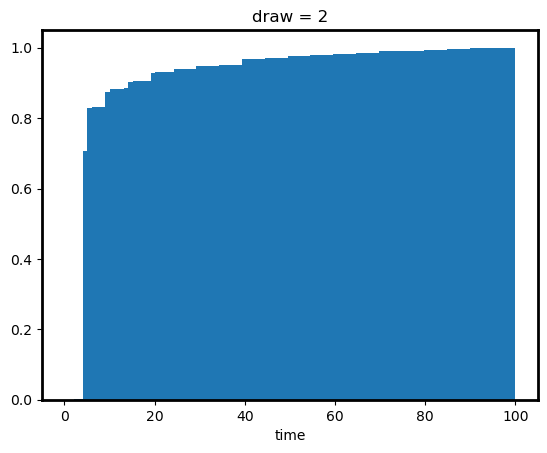

In [76]:
dt = ds_.time.diff(dim='time')/np.timedelta64(1, 'm')
dt.plot.hist(cumulative=True, density=True, bins= np.linspace(0, 100, 100))